### Data Loader log analyser
Text report
- Responses count
- Unique entities count
- Avg. response time
- Stats by response code (requests count and avg. response time)
- Stats by process

Drawing charts
- Requests per time
- Avg. response time
- Response time by status code

In [33]:
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

In [34]:
load_dotenv()
reports_folder = os.environ.get('REPORTS_FOLDER')

#### Edit log file name below

In [35]:
report_file = "./logs/20230429_214023.log" # "20230501_152144.log"

groupby_type = "MINUTES" # SECONDS

In [36]:
# Reading data from file
# Filtering lines in wrong format
file = open(report_file, 'r')

data = []
skipped_rows = 0
while file:
    line = file.readline()
    if line == "":
        break
        
    values = line.strip().split(";")
    if len(values) != 6:
        skipped_rows += 1
    else:
        data.append(values)
        
print("Log parsing results:")
print(f"- Lines loaded {len(data)}")
print(f"- Rows skipped {skipped_rows}")

Log parsing results:
- Lines loaded 66095
- Rows skipped 14


In [37]:
# Preparing data
# Converting formats
# Droping unnecessary cols

df_log = pd.DataFrame(data, columns=["Date", "Level", "Process", "Entity", "Code", "Response"])
df_warnings = df_log[df_log["Level"] == 'WARNING']
df_errors = df_log[df_log["Level"] == 'ERROR']

df_log['Date'] = pd.to_datetime(df_log['Date'])
str_format = "%H:%M" if groupby_type == "MINUTES" else "%H:%M:%S" 
df_log['Time'] = df_log['Date'].dt.strftime(str_format)
    
# df_log['Code'] = df_log['Code'].astype(int)
df_log['Response'] = pd.to_timedelta(df_log['Response'])
df_log['Response time'] = df_log['Response'].dt.total_seconds()

df_log.drop(['Level', 'Date', 'Response'], axis=1, inplace=True)

print("Data sample")
print(tabulate(df_log.head(10), headers=["Process", "Entity", "Code", "Time", "Response time"], showindex=False))

Data sample
Process      Entity                                        Code  Time      Response time
-----------  ------------------------------------------  ------  ------  ---------------
receiver-1   0xc3986ac1e3c682f734c687c899d73da7e0524ad8     200  21:40          0.207092
receiver-3   0x3a03f68b9aab8d4aa68896cdf8583189206678dc     200  21:40          0.191072
receiver-0   0xdca4b5f0eaba1f2eaae3aafb13e3836d6441e0a7     200  21:40          0.212171
receiver-2   0xa61301a5199671ab6c5d2e21c718fddbdab778e3     200  21:40          0.186584
receiver-5   0x54a1f9674daaad0c61b346bf4018f4dd60390363     200  21:40          0.182563
receiver-11  0x3eb72125ff02a0e1e6276b66f0832835f4fc9337     200  21:40          0.225864
receiver-4   0x778cb94a215518266448d7ae81bd4a734a7efc92     200  21:40          0.229616
receiver-7   0xec9ff02779c0580c757483a82f26729068f4f710     200  21:40          0.231252
receiver-1   0x24bbbb243766a7ddc71244bdb45e1b0865111252     200  21:40          0.20606
receiver-6

In [38]:
# Preparing text report
print(f"Text report:\n")

# Responses count
responses_count = len(df_log.index)
print(f"1. Responses count: {responses_count}\n")

# Unique entities
unique_entities_count = len(pd.unique(df_log['Entity']))
print(f"2. Unique entities count: {unique_entities_count}\n")

# Avg response time
avg_response_time = df_log['Response time'].mean()
print(f"3. Avg. response time: {round(avg_response_time, 4)}s.\n")

# Stats by code
responses_by_code = (df_log.groupby("Code").agg(
                                            Count=('Entity', 'count'), 
                                            AvgResponseTime=('Response time', 'mean')))

responses_by_code = responses_by_code.reset_index().sort_values("Count", ascending=False)

print("4. Stats by response code\n")
_headers = ['Status code', "Requests count", "Avg. response time"]
print(tabulate(responses_by_code, headers=_headers, showindex=False))
print("\n")

# Avg response time by code
print("5. Stats by process\n")
responses_by_process = (df_log.groupby(["Process"]).agg(
                                            Count=('Entity', 'count'), 
                                            AvgResponseTime=('Response time', 'mean')))
responses_by_process = responses_by_process.reset_index()
responses_by_process = responses_by_process.sort_values("Count", ascending=False)
_headers = ['Process', 'Requests count', 'Avg. responce time']
print(tabulate(responses_by_process, headers=_headers, showindex=False))

Text report:

1. Responses count: 66095

2. Unique entities count: 66095

3. Avg. response time: 0.2315s.

4. Stats by response code

  Status code    Requests count    Avg. response time
-------------  ----------------  --------------------
          200             66081              0.228359
          504                14             15.1706


5. Stats by process

Process        Requests count    Avg. responce time
-----------  ----------------  --------------------
receiver-18              4012              0.225658
receiver-1               4000              0.226763
receiver-16              3998              0.225517
receiver-13              3990              0.22657
receiver-6               3990              0.226557
receiver-15              3952              0.229587
receiver-8               3918              0.230277
receiver-2               3915              0.231013
receiver-10              3912              0.232309
receiver-11              3901              0.233198
receiv

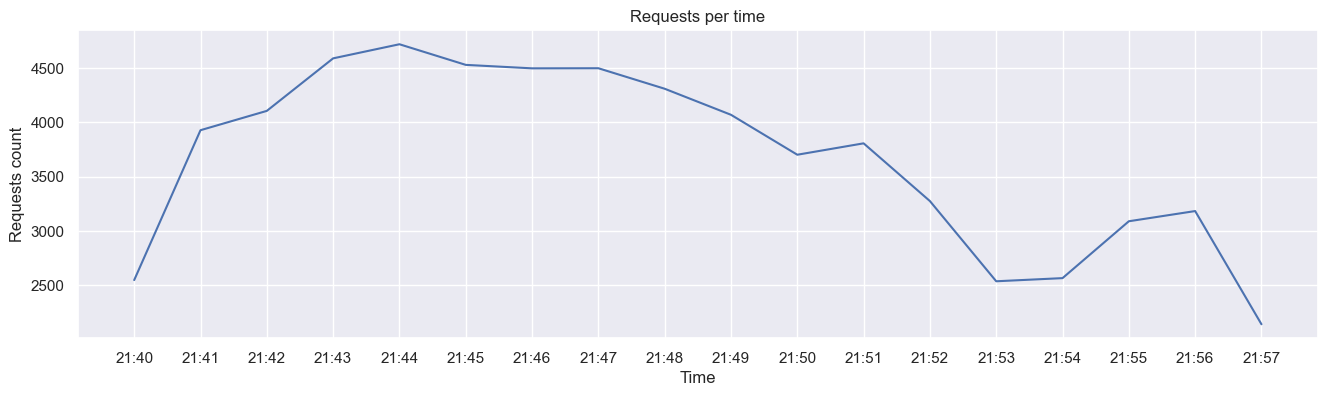

In [39]:
df_requests = df_log.groupby('Time').agg("Entity").count()

# Building request per time plot
plt.figure(figsize=(16, 4))
sns.set_theme()
plot = sns.lineplot(data=df_requests, markers=True)
plot.set(title='Requests per time', ylabel='Requests count')
plt.show()

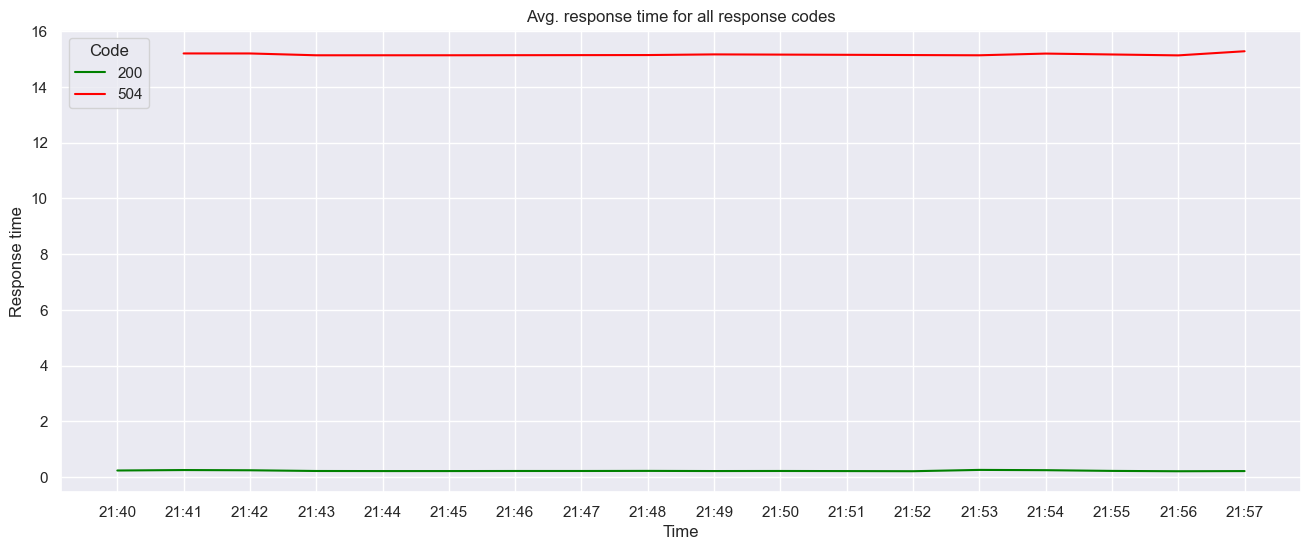

In [40]:
# Building avg response time plot
plt.figure(figsize=(16, 6))
sns.set_theme()

df_requests_type = df_log.groupby(['Time', 'Code']).agg({"Entity": "count", "Response time": "mean"}).reset_index()
palette=['green','red'] #, 'orange','brown','dodgerblue']
plot_all = sns.lineplot(data=df_requests_type, x="Time", y="Response time", hue="Code", palette=palette)
plot_all.set(title='Avg. response time for all response codes')
plt.show()

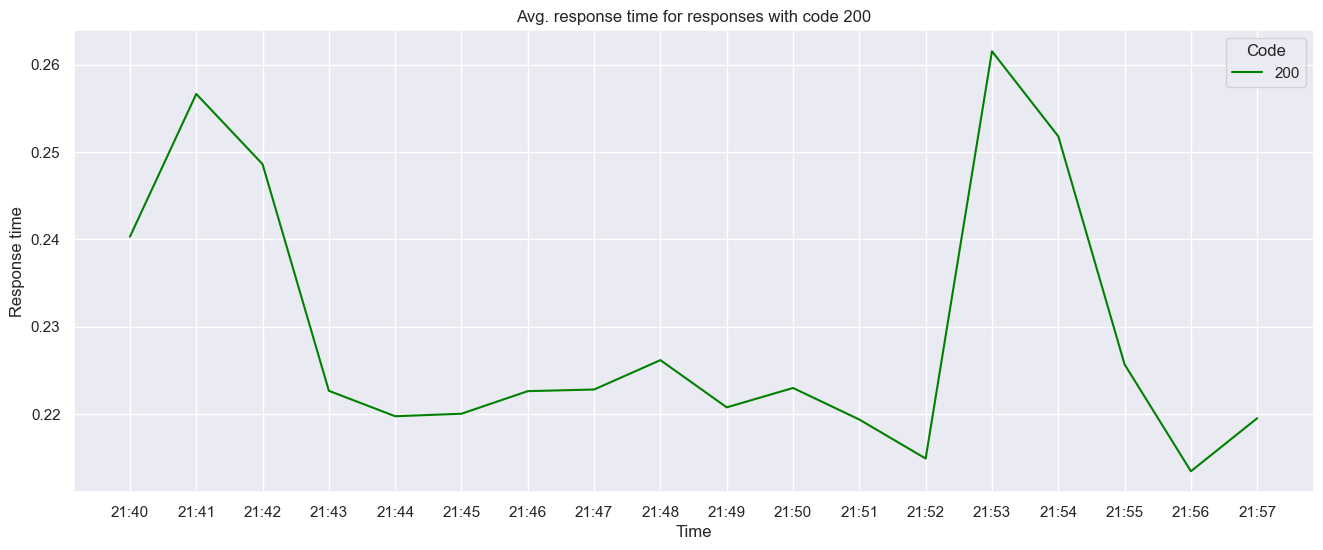

In [51]:
# Building avg time plot for responses with code 200
plt.figure(figsize=(16, 6))
sns.set_theme()

df_requests_type = df_log.groupby(['Time', 'Code']).agg({"Entity": "count", "Response time": "mean"}).reset_index()

plot_all = sns.lineplot(data=df_requests_type[df_requests_type['Code']==200], 
                        x="Time", 
                        y="Response time", 
                        hue="Code", 
                        palette=palette)

plot_all.set(title='Avg. response time for responses with code 200')
plt.show()

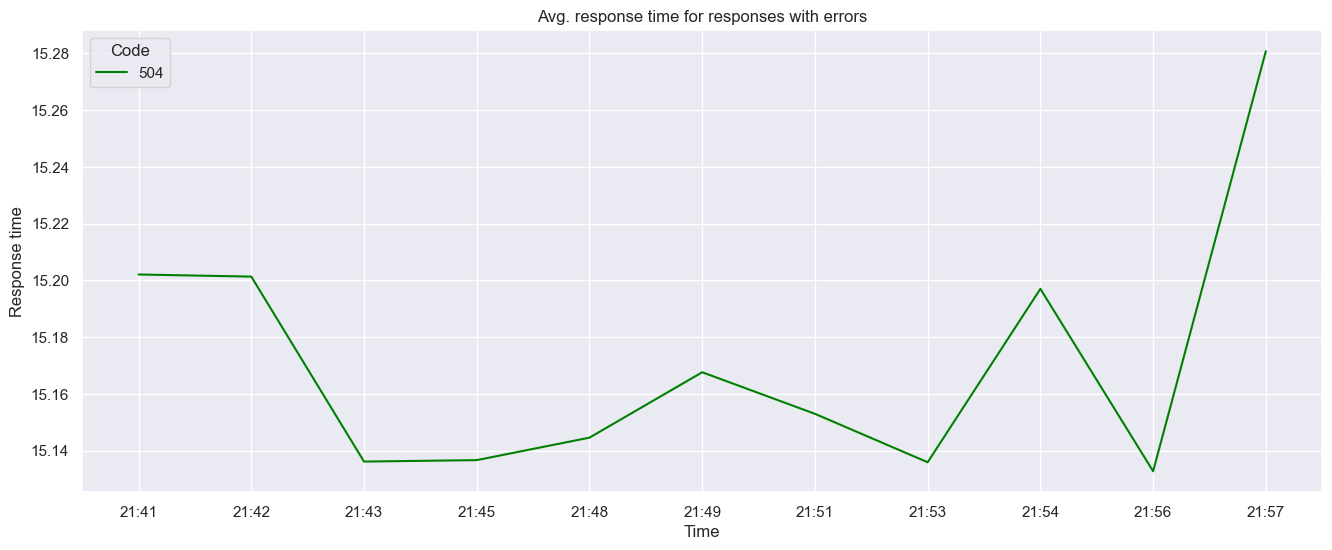

In [47]:
# Building avg 300/400/500 response time plot
plt.figure(figsize=(16, 6))
sns.set_theme()

df_requests_type = df_log.groupby(['Time', 'Code']).agg({"Entity": "count", "Response time": "mean"}).reset_index()

plot_all = sns.lineplot(data=df_requests_type[df_requests_type['Code']!=200], 
                        x="Time", 
                        y="Response time", 
                        hue="Code", 
                        palette=palette)

plot_all.set(title='Avg. response time for responses with errors')
plt.show()

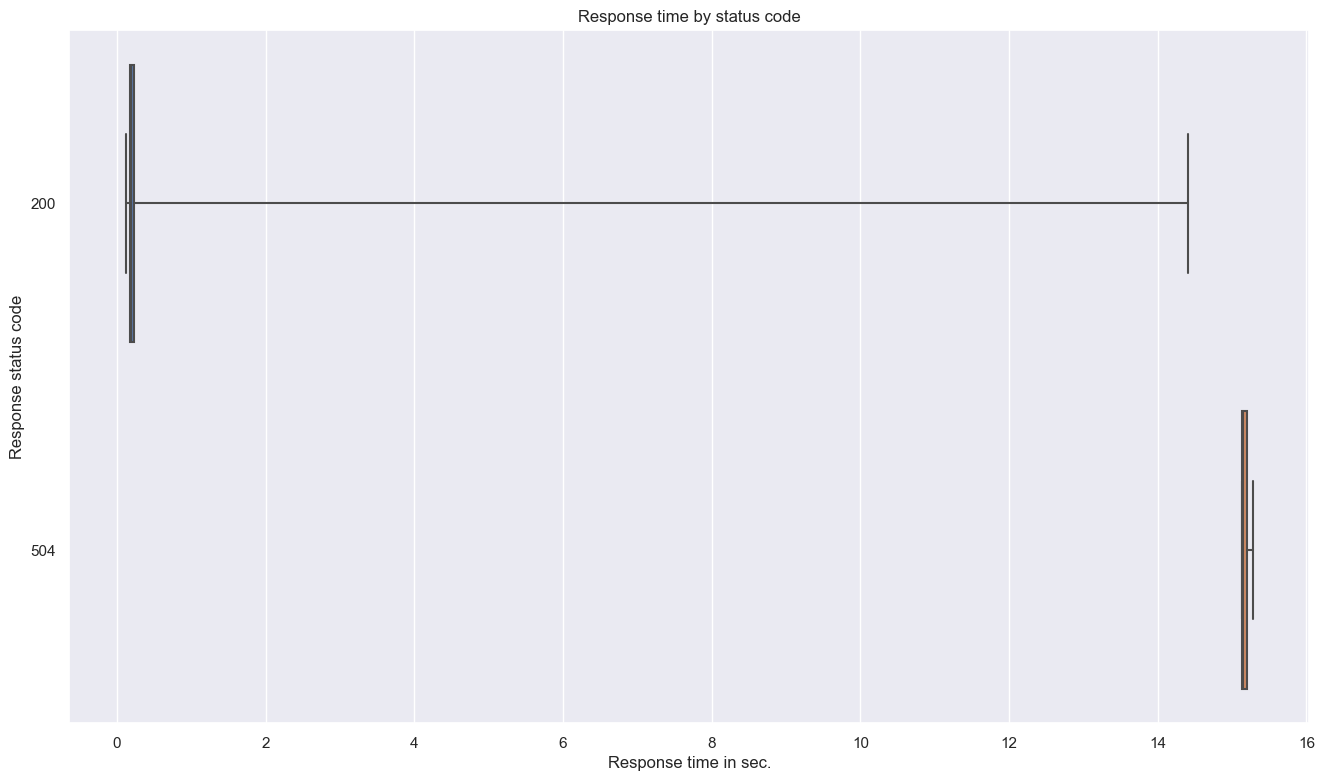

In [46]:
# Preparing response time by status code plot
plt.figure(figsize=(16, 9))
sns.set_theme()

df_box = df_log
df_box['Code'] = df_box['Code'].astype(int)

plot = sns.boxplot(data=df_log, 
                   y="Code", 
                   x="Response time", 
                   whis=[0, 100], 
                   orient="h")

plot.set(title='Response time by status code', 
         ylabel="Response status code", 
         xlabel="Response time in sec.")

plt.show()

In [55]:
# Top slowest responses
limit = 5

df_log = df_log.sort_values('Response time', ascending=False)
sample = df_log.iloc[0:limit]

sample.reset_index(inplace=True, drop=True)

_headers = ['Process', 'Entity', 'Code', 'Time', 'Request time']
print(tabulate(sample, headers=_headers))

    Process      Entity                                        Code  Time      Request time
--  -----------  ------------------------------------------  ------  ------  --------------
 0  receiver-8   0x1062a747393198f70f71ec65a582423dba7e5ab3     504  21:57          15.2807
 1  receiver-7   0x96fa6acfc5f683db191234c74d315e5d732b07c0     504  21:54          15.2417
 2  receiver-9   0x7035ddda96657834e5f096026232d3ac7c2613ab     504  21:41          15.2021
 3  receiver-4   0x740d5718a79a8559feee8b00922f8cd773a81d84     504  21:42          15.2014
 4  receiver-19  0xd99e689d41afde916aafd566765f85edad09fd92     504  21:49          15.1863


In [52]:
#### Take a look on warnings and errors
print(df_warnings[["Entity", "Code", "Response"]][:10])

                                           Entity Code        Response
6066   0x841394557825e787589ea08d10bab8f00402f807  200  0:00:02.190479
7929   0x2d838fdf8cc801b65cfbafa19500571ac10dbe38  200  0:00:02.175114
8513   0x3485ebe27eb7b2e9b20692e3c36d312af40fa9b7  200  0:00:02.068664
8597   0x17f1a51da68d27c94d2a51d92b27b5bd4718b986  200  0:00:02.802790
10024  0x306e4bfcf660f8ec775fa5b2689f27f3b8e613cf  200  0:00:02.287499
10025  0x86e27b0056e8b58041bd77db30ded50f247690db  200  0:00:02.289311
10026  0xe29c1e5da6ab804f4f21756dc49aa6fec7315b14  200  0:00:02.337464
10032  0x9ddc3cbf350a0cb116dfa7a6c78f27ff1e1b779c  200  0:00:02.334571
10036  0x4425a1f92e4cbbd00f931bc65187eda000e0e390  200  0:00:02.378509
11116  0xb2e2b1f036f31a9a97d3fc377a47581c813123aa  200  0:00:07.461546


In [53]:
#### Take a look on errors
print(df_errors[["Entity", "Code", "Response"]][:10])
# df_errors.to_csv("./warnings.csv", sep=";")


                                           Entity Code        Response
4083   0x7035ddda96657834e5f096026232d3ac7c2613ab  504  0:00:15.202105
7967   0x740d5718a79a8559feee8b00922f8cd773a81d84  504  0:00:15.201357
14361  0x43ebc0b49617f896f3087e89fbbafdc7f01efe22  504  0:00:15.136202
20734  0x472276d38303f69915d9d9873969fc45c6d28c62  504  0:00:15.136708
35446  0x33da80ce59602c2d66da944392cdf95bd4928c5e  504  0:00:15.144625
37801  0x657439ed989b0ec28a09b592fda8c61ebd434b6a  504  0:00:15.149053
40688  0xd99e689d41afde916aafd566765f85edad09fd92  504  0:00:15.186283
45627  0xb1f1c46ecec6748c1f1e6d6bccff1fc9417318c0  504  0:00:15.153024
52715  0xe03c23519e18d64f144d2800e30e81b0065c48b5  504  0:00:15.128561
53740  0xc06699ae49ceb6856478ef0eea23181a5cc2c9b7  504  0:00:15.143355
